In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

In [3]:
import importlib

In [4]:
importlib.reload(model)

<module 'model' from '/media/itasarom/7158f0d7-af1d-45d4-855f-86204aed5a8b/Projects/diplom/GAN/model.py'>

In [5]:
def normalize_embeddings(embeddings):
    EPS = 1e-9
    mean = embeddings[1:].mean(axis=0, keepdims=True)
    se = (embeddings[1:].var(axis=0, keepdims=True)  + EPS )**0.5
#     embeddings
    embeddings = (embeddings - mean)/se
    embeddings[0, :] = 0
    return embeddings

In [6]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='fr', max_sent_length=100)
# vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es', max_sent_length=100)
# vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ru')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='en', max_sent_length=100)

In [7]:
# vocab1.embeddings.var(axis=0)

In [8]:
vocab1.embeddings = normalize_embeddings(vocab1.embeddings)
vocab2.embeddings = normalize_embeddings(vocab2.embeddings)

In [9]:
# vocab1.embeddings.var(axis=0)

In [10]:
len(vocab1.embeddings), len(vocab2.embeddings)

(47377, 47404)

In [11]:
len(sents1), len(sents2)

(18641, 17860)

In [12]:
torch.cuda.is_available()

True

In [13]:
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels, max_sent_length=None)

In [14]:
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels, max_sent_length=None)

In [15]:
print(len(sent_sampler_1.sents), len(sent_sampler_2.sents))

18641 17860


In [16]:
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)

In [17]:
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [18]:
import IPython


In [19]:
cls = model.GAN(100, len(all_labels))

In [20]:
cls = cls.cuda()

In [21]:
# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':1,
#     'transform_iterations':500,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':2,
#     'discr_iterations':1,
#     'transform_iterations':5,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint_2_layers.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':10,
#     'transform_iterations':20,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':1024,
#     'n_discr_2':1024,
#     'n_iter':100
    
# }


params = {
    'save_path': "./model_checkpoint_sentences_fr_en_no_classifier.tc",
    'save_every':10,
    'sentence_iterations':50,
    'discr_iterations':10,
    'transform_iterations':25,
    'n_sents_1':256,
    'n_sents_2':256,
    'n_discr_1':1024,
    'n_discr_2':1024,
    'n_iter':100,
    'validate_every':1
    
}

In [22]:
# trainer.global_iterations = 60

In [23]:
trainer = util.Trainer(cls)

In [24]:
# trainer.restore("./model_checkpoint_sentences.tc")
# # cls.train()

In [25]:
# torch.abs(cls.transformation_1.bias - cls.transformation_2.bias).max()[0
# sents1[0]

In [26]:
# vocab1.embeddings[40]
# [k for k in vocab1.transformation if vocab1.transformation[k] == 40 ]

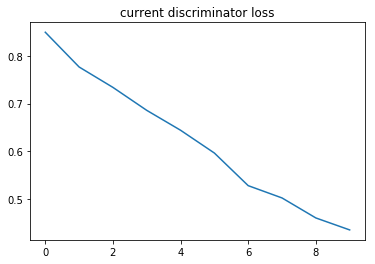

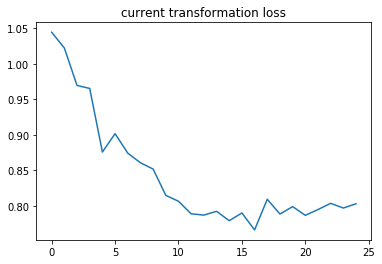

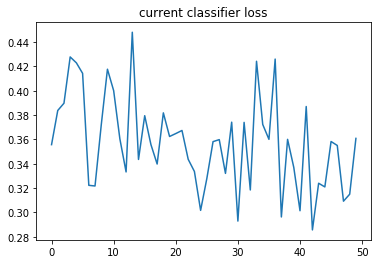

Iter 199 class 0.35753506422042847, discr0.6212482452392578, transform 0.8428704738616943


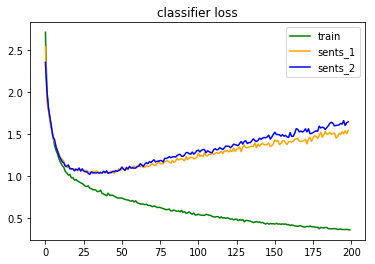

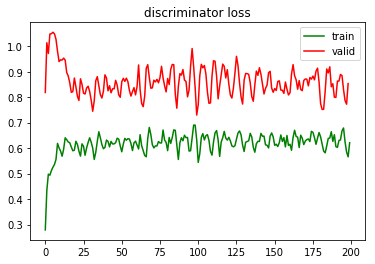

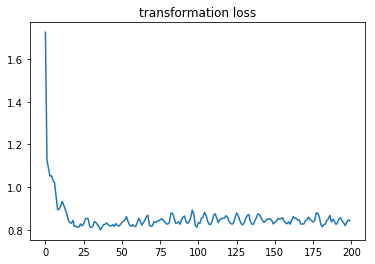

after epoch_id


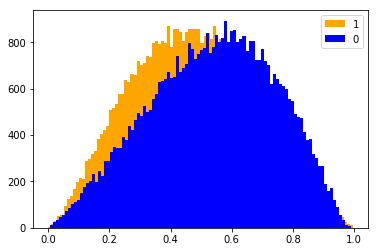

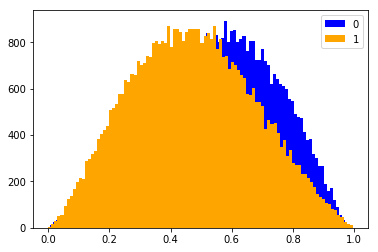

Embedding accuracy  0.42969582511262805
Embedding loss  0.8769545506134063
Confusion matrix
 [[19874. 27503.]
 [26551. 20853.]]
Min component variance 0.20645852386951447, median component variance 0.3302413523197174, mean component variance 0.3276459574699402, max c v 0.6067322492599487
Sents1 (665, 1024, 0.6494140625) [1.5383054]
Sents2 (683, 1024, 0.6669921875) [1.6240664]


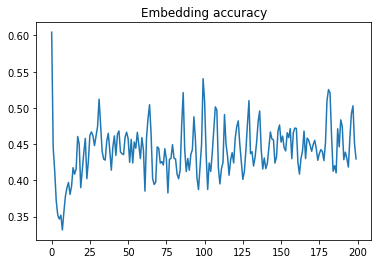

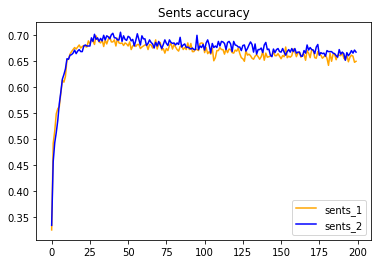

In [77]:
# trainer.t
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

In [28]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [29]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [30]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [31]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [32]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    
    plt.legend()
    plt.show()
    

    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

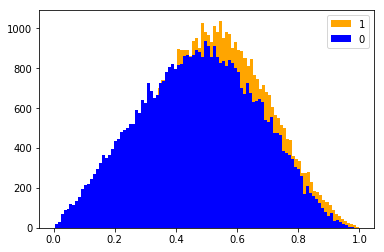

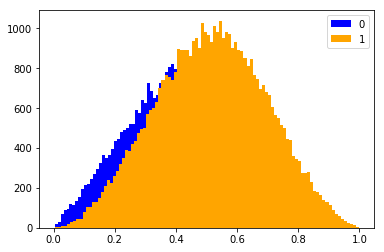

Accuracy  0.540340363574978
Loss  0.7296782651625182
Confusion matrix
 [[25796. 21581.]
 [21986. 25418.]]
Min component variance 0.2804757058620453, median component variance 0.4446263313293457, mean component variance 0.44304946064949036, max c v 0.6211516857147217
Total length  94781


In [33]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [34]:
# cls.discriminator.actual_model.zero_grad()

In [35]:
embeds = result[-1]

In [36]:
embeds = normalize_embeddings(embeds)

In [37]:
embeds1 = embeds[:len(vocab1.embeddings)]
embeds2 = embeds[len(vocab1.embeddings):]

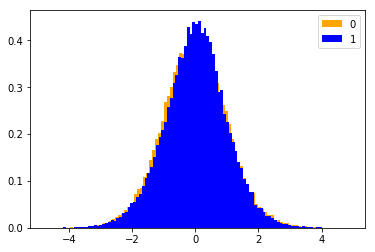

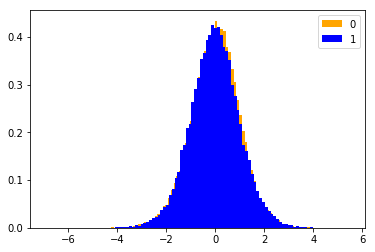

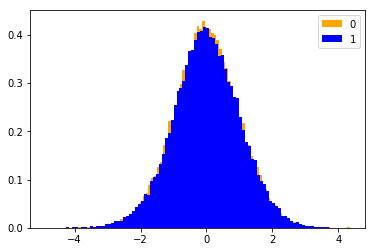

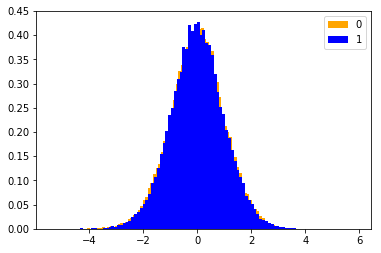

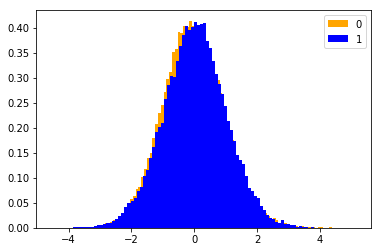

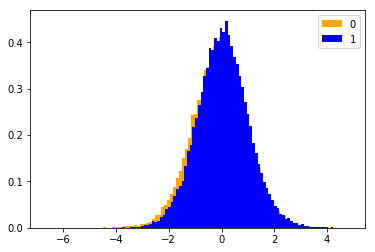

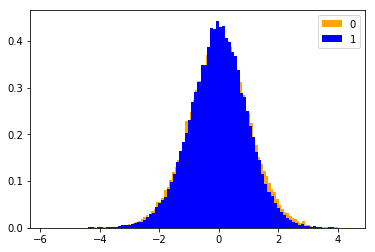

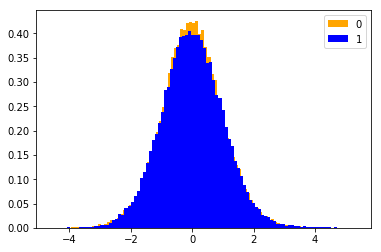

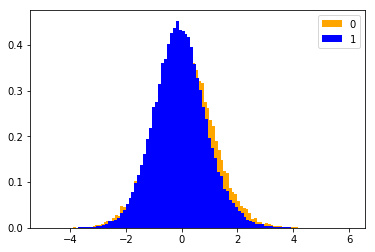

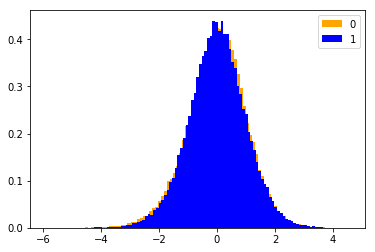

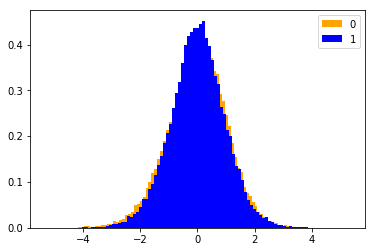

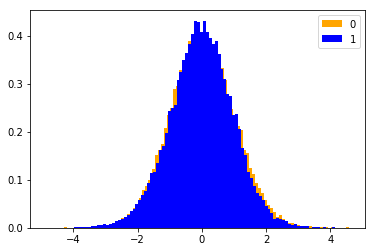

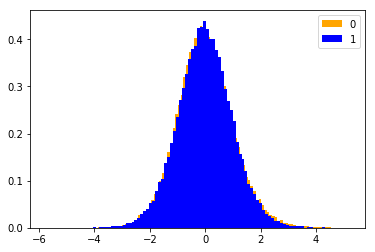

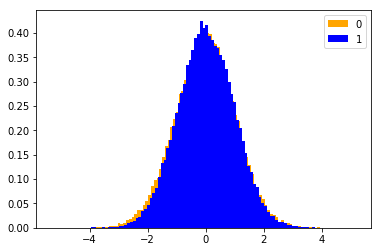

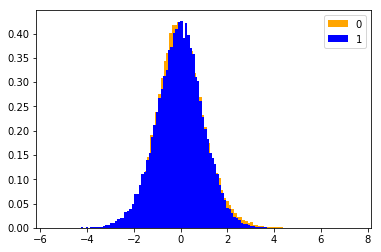

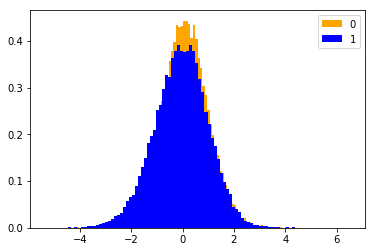

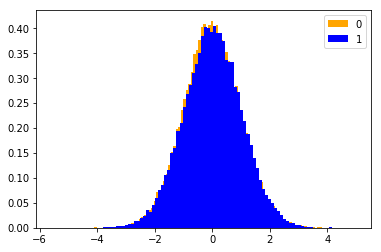

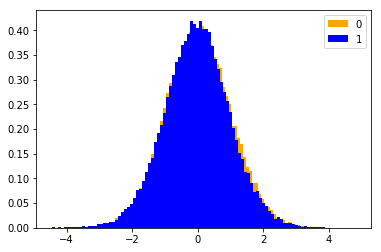

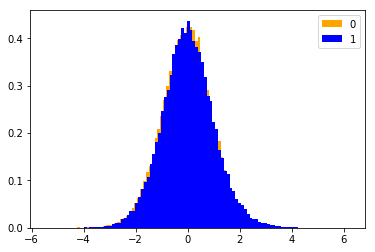

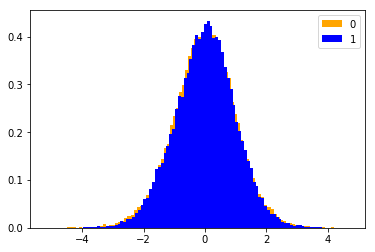

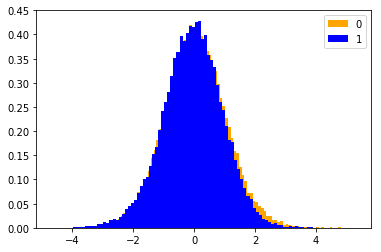

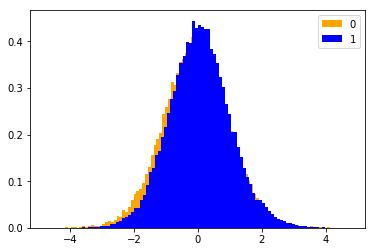

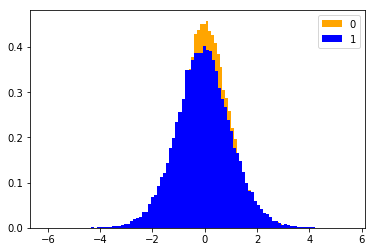

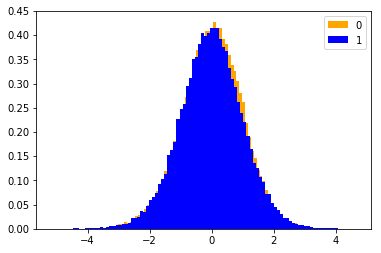

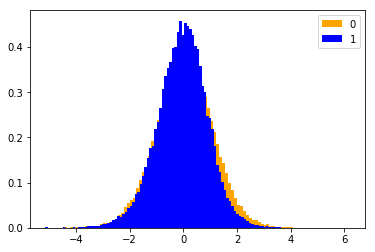

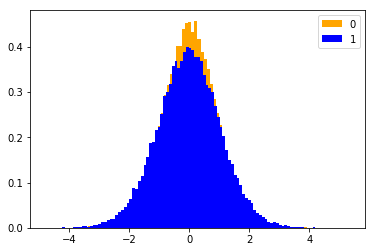

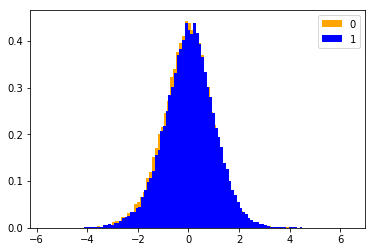

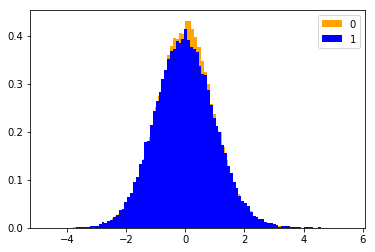

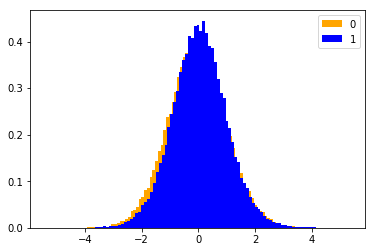

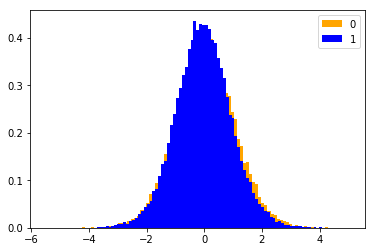

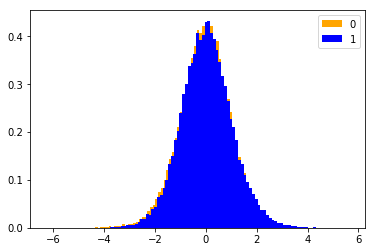

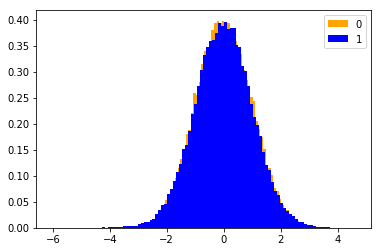

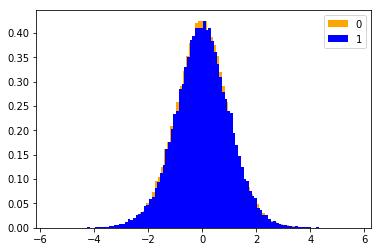

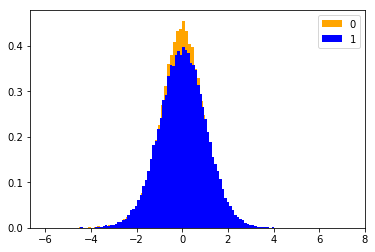

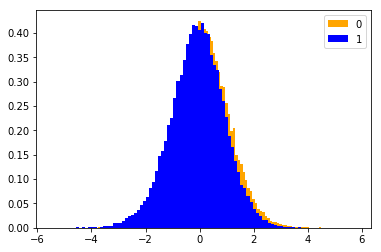

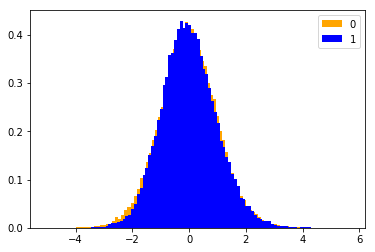

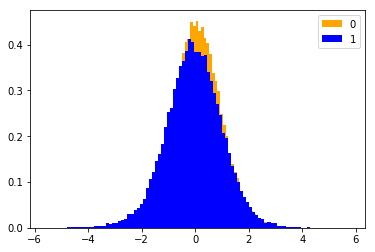

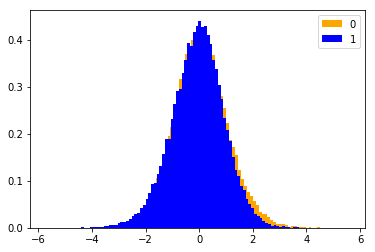

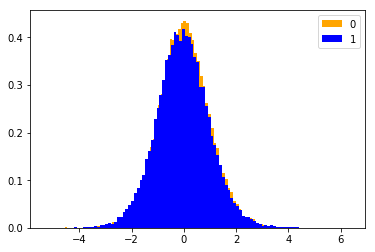

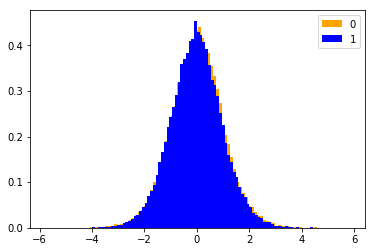

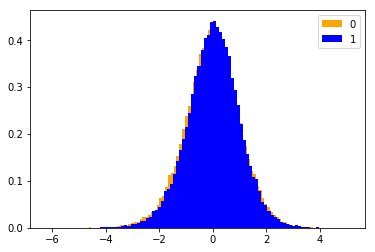

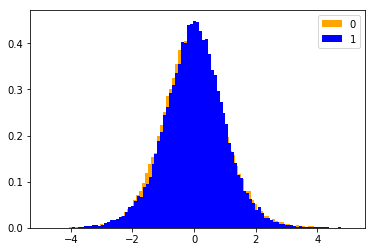

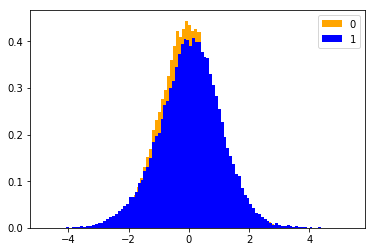

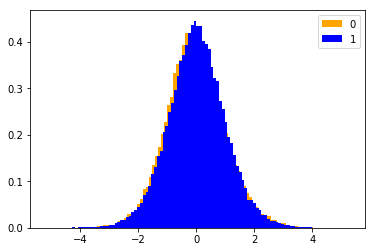

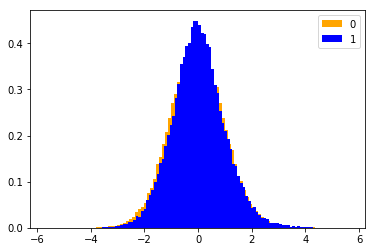

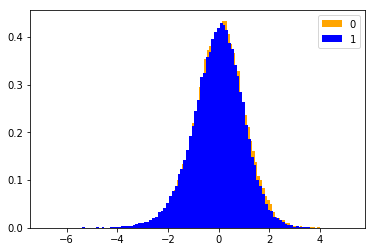

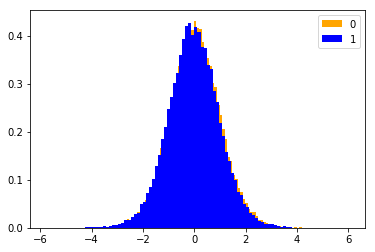

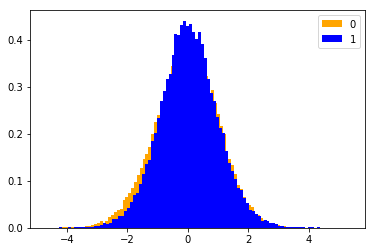

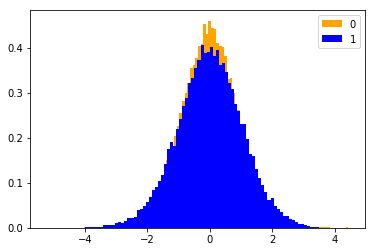

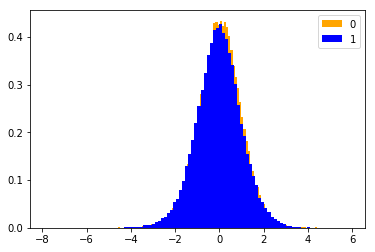

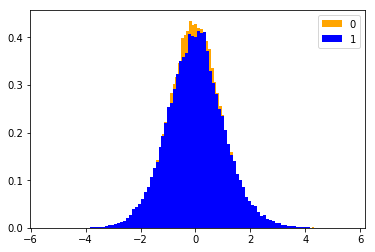

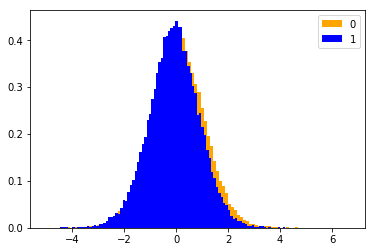

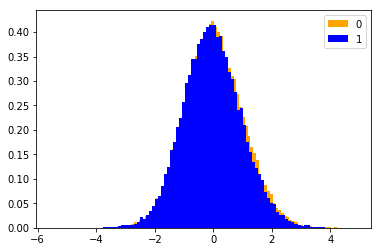

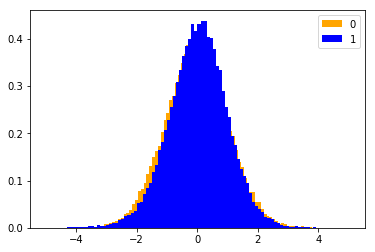

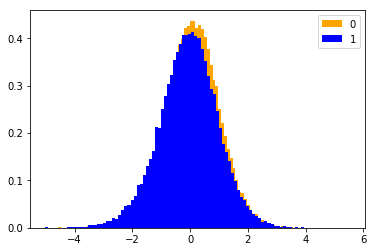

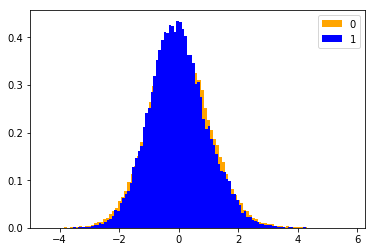

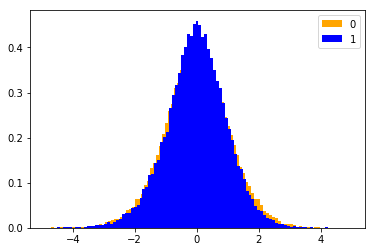

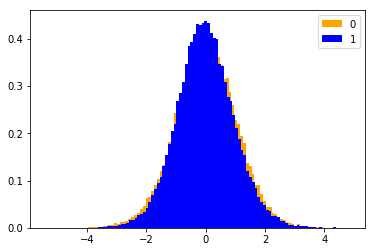

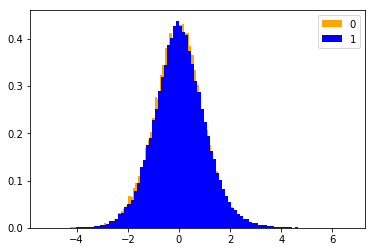

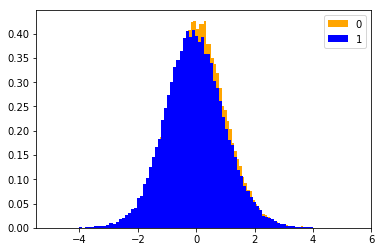

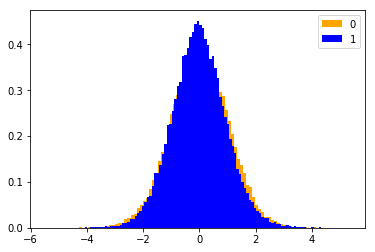

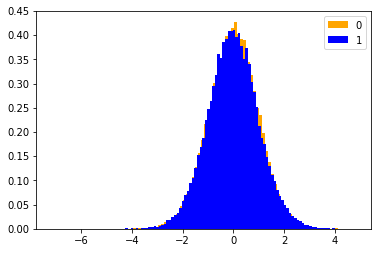

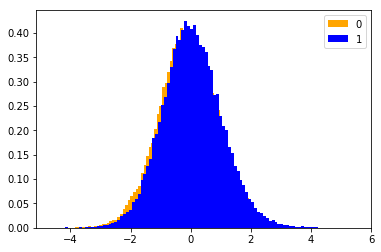

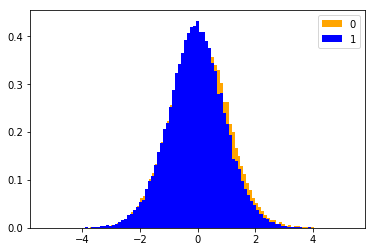

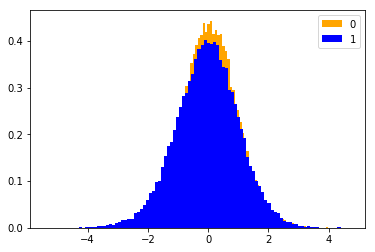

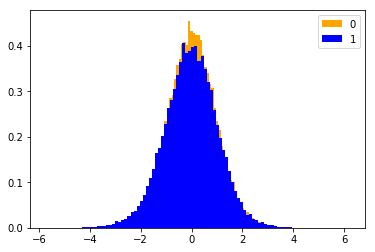

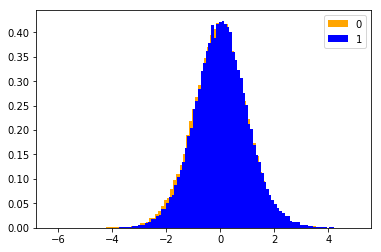

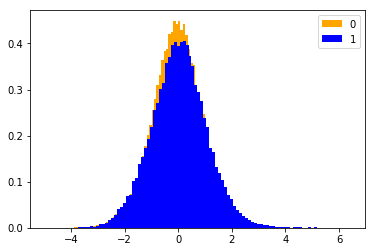

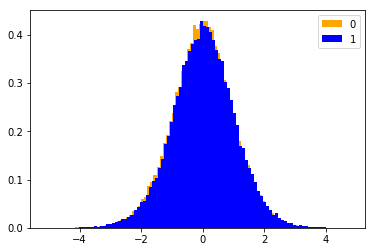

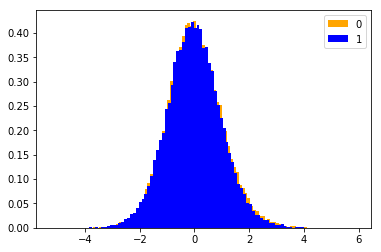

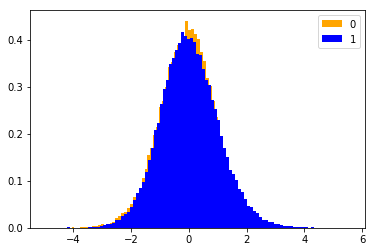

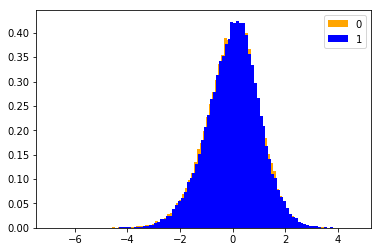

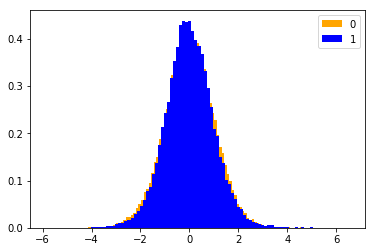

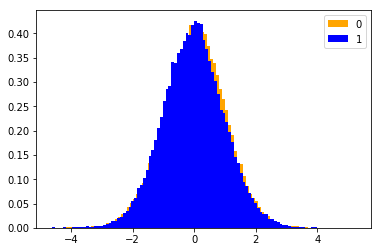

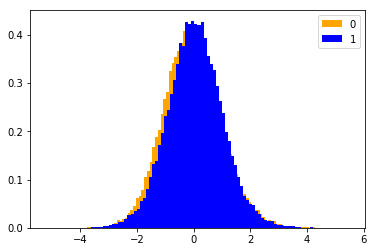

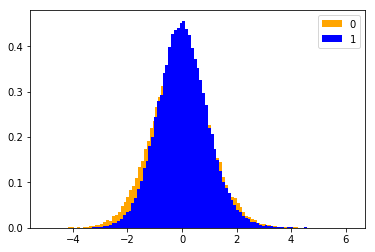

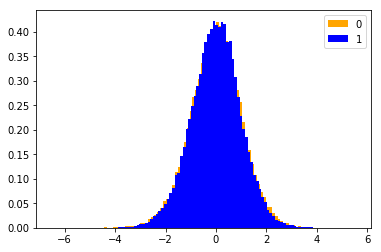

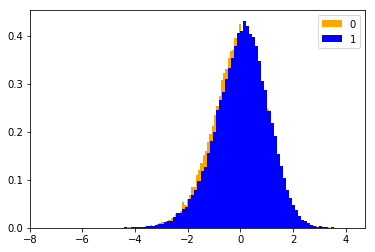

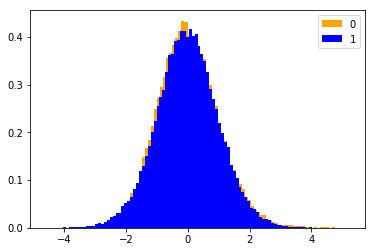

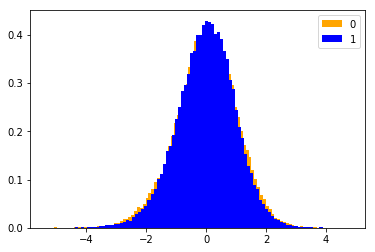

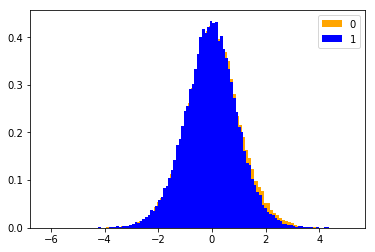

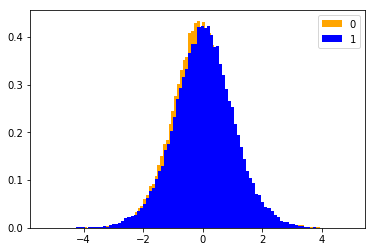

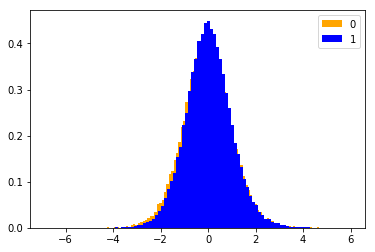

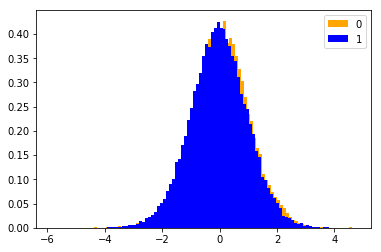

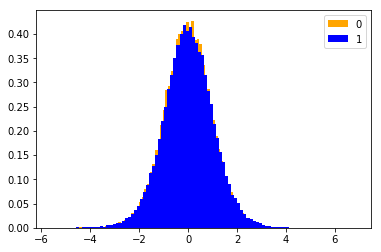

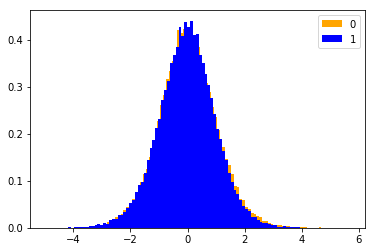

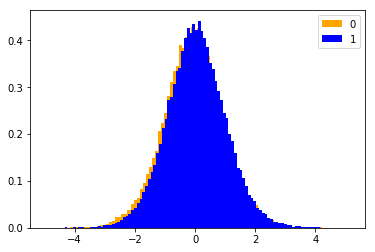

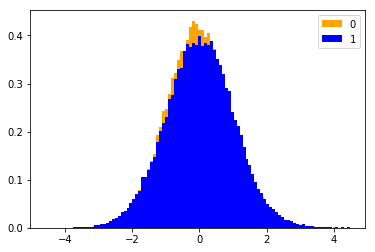

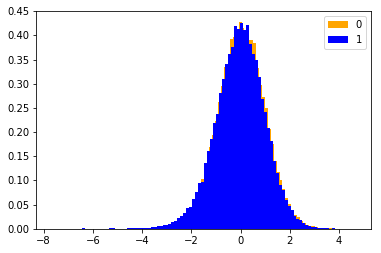

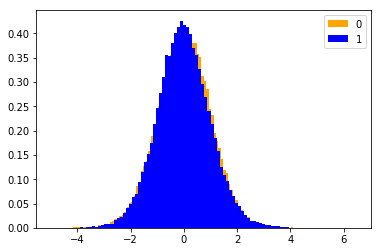

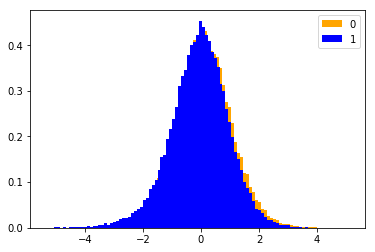

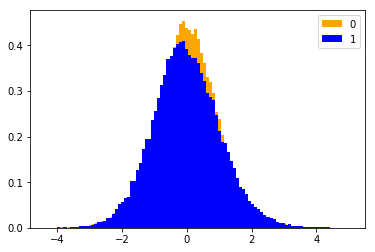

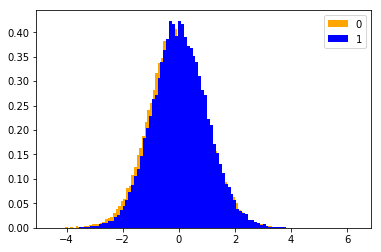

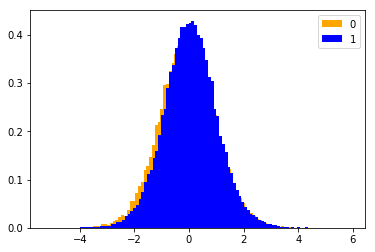

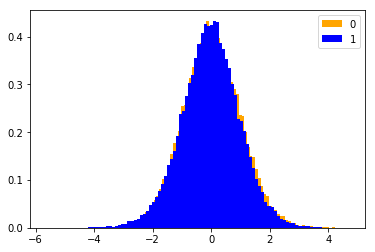

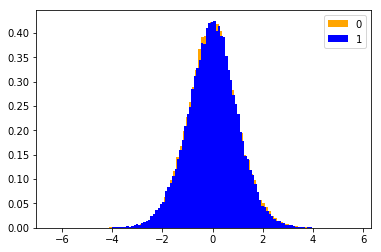

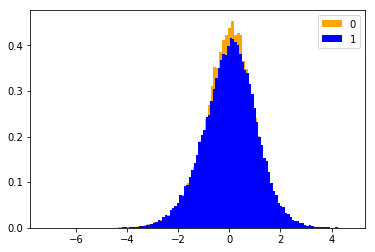

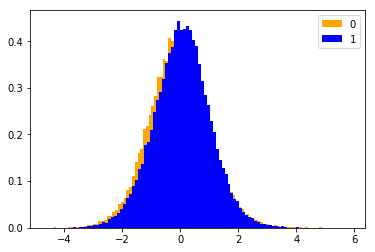

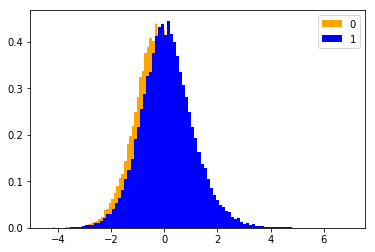

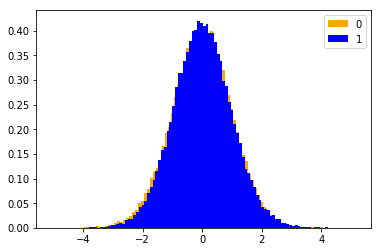

In [38]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [39]:
import evaluation

In [40]:
def describe(sent_sampler, model, transformation):
    model.eval()
    x, mask, y = sent_sampler.get_test()
    true_y = np.zeros(shape=(len(y), len(sent_sampler.unique_labels)), dtype=np.int32)
    for idx, current_y in enumerate(y):
        true_y[idx, current_y] = 1
    
    x, mask, y = model.prepare_data_for_classifier(x, mask, y, transformation)
    
    if model.is_cuda:
        x = x.cuda()
        y = y.cuda()
        mask = mask.cuda()
    

    
    loss = model.classifier.get_loss(x, mask, y).data.cpu().numpy()
    probs = model.classifier(x, mask)[1].data.cpu().numpy()
    
    pred = np.argmax(probs, axis=1)
    
    acc = evaluation.accuracy(predicted_probs=probs, true_y=true_y)
    prec = {}
    rec = {}
    for cls in range(true_y.shape[1]):
        prec[cls] = evaluation.precision_by_class(probs, true_y, cls)
        rec[cls] = evaluation.recall_by_class(probs, true_y, cls)
    
    return acc, prec, rec, evaluation.build_confusion_matrix(probs, true_y)

    

In [41]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform1)

In [42]:
print(acc, len(sent_sampler_1.sents))

(700, 1024, 0.68359375) 18641


In [43]:
print(acc, len(sent_sampler_1.sents))

(700, 1024, 0.68359375) 18641


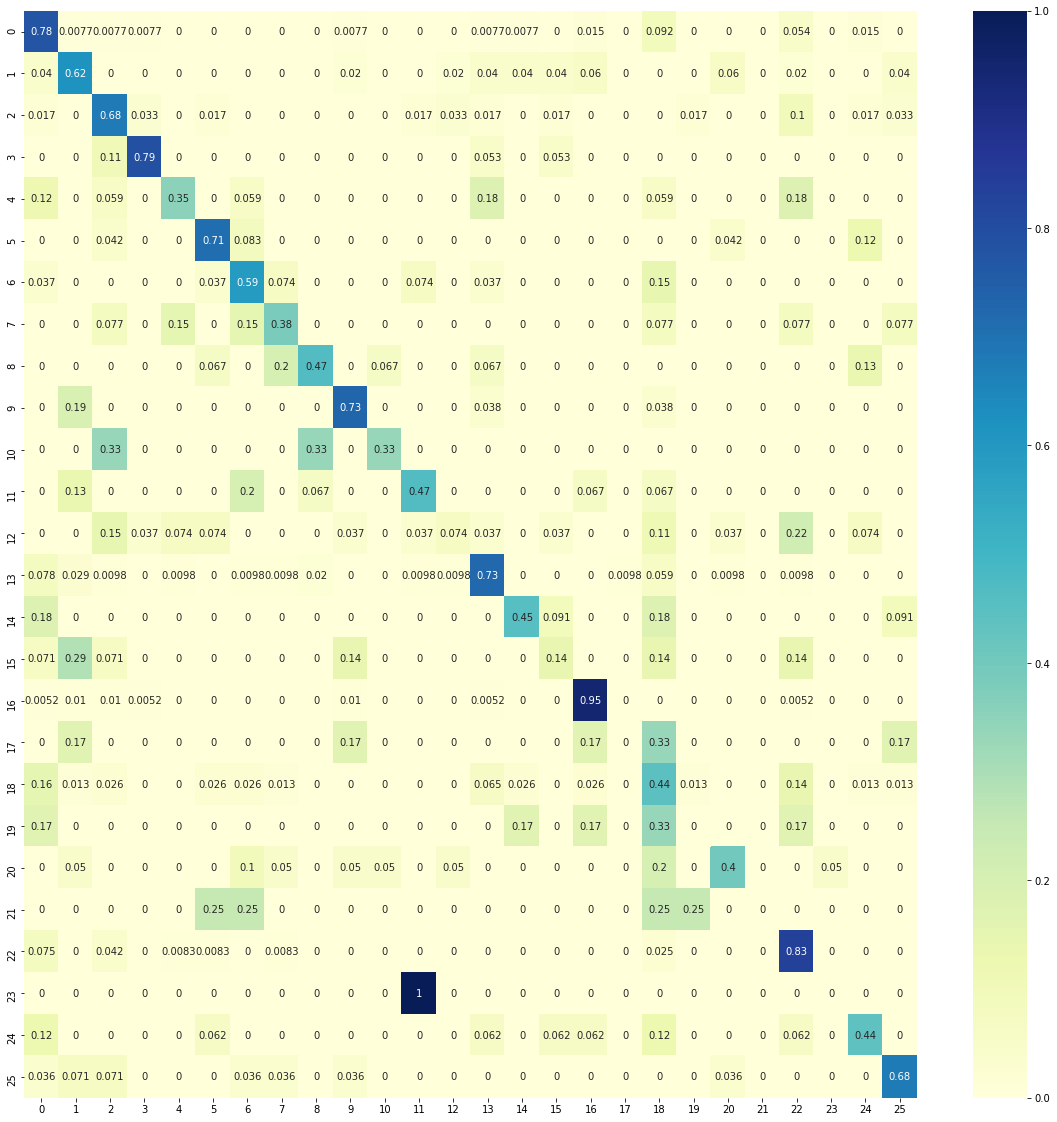

In [44]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [45]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_2, cls, cls.transform2)

In [46]:
print(acc, len(sent_sampler_2.sents))

(698, 1024, 0.681640625) 17860


In [47]:
print(acc, len(sent_sampler_2.sents))

(698, 1024, 0.681640625) 17860


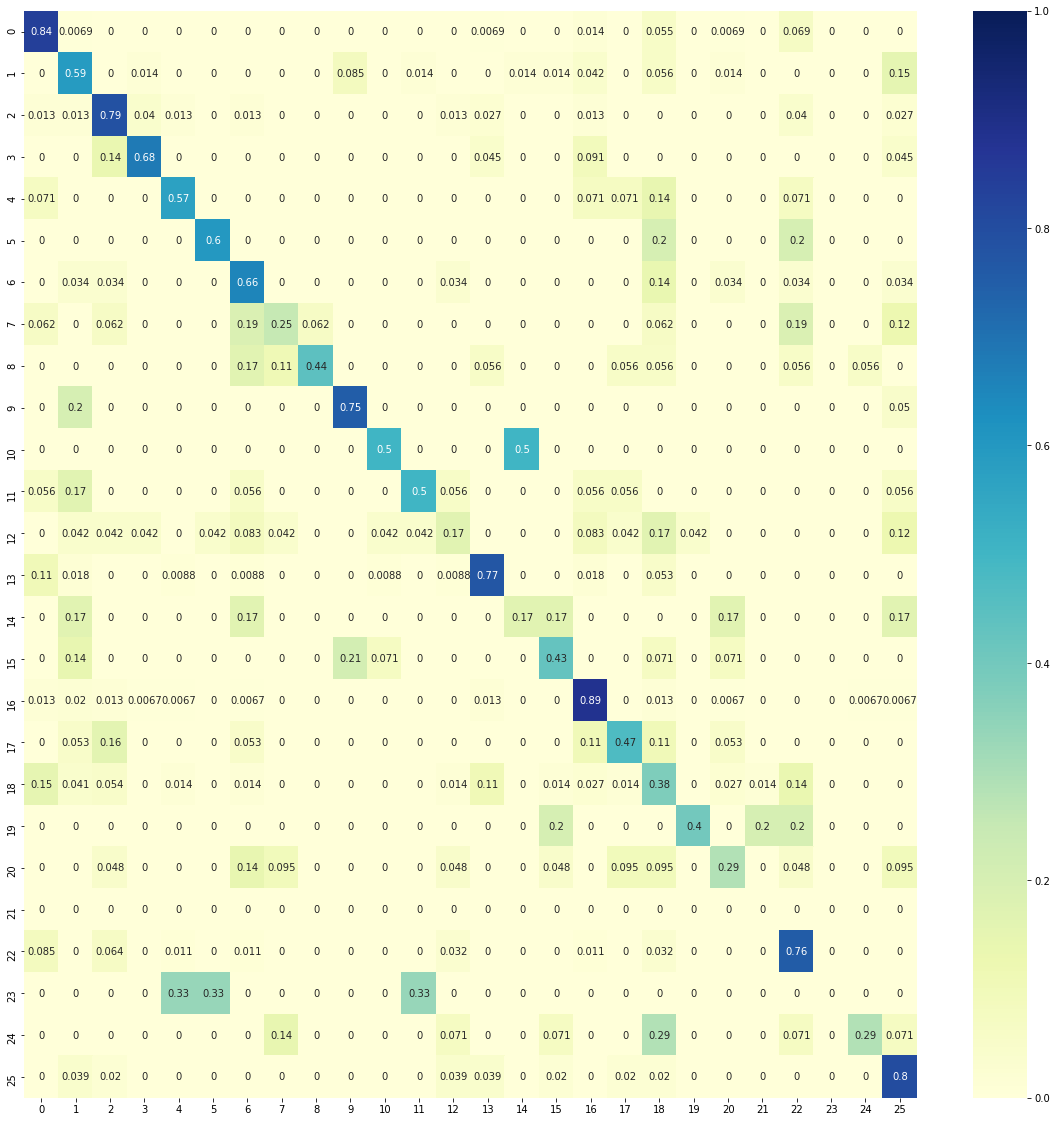

In [48]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [49]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform2)

In [50]:
acc

(53, 1024, 0.0517578125)

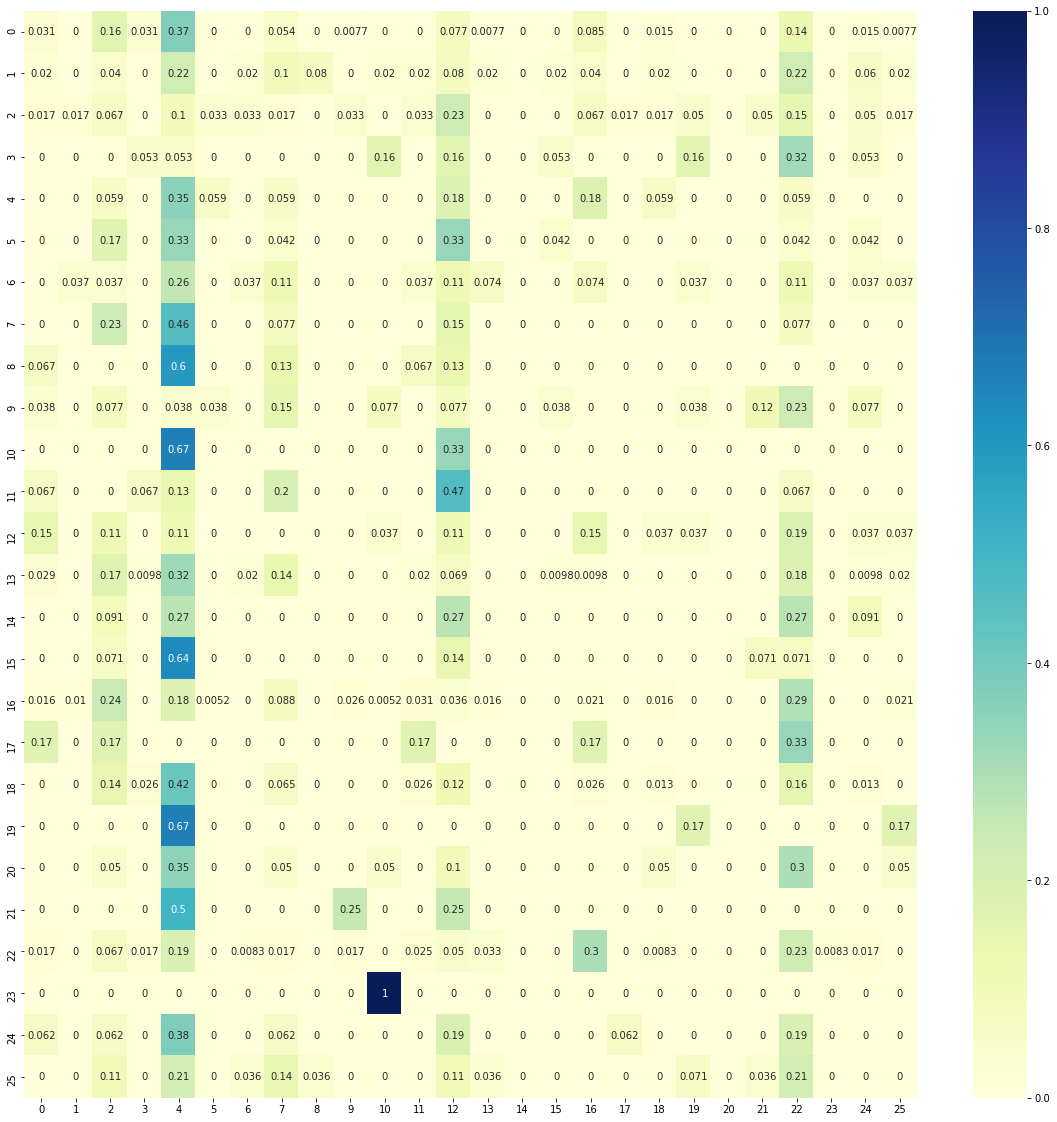

In [51]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [52]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, model.IdentityTransformation())

In [53]:
acc

(64, 1024, 0.0625)

In [68]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [54]:
# s ="""
# ayudar
# familia
# grupo
# mira
# poseer
# presidente
# alto
# hombre
# venir
# octubre
# grande
# cada
# cosa
# mujer
# encontrar
# público
# campaña
# agua
# izquierda
# bueno
# país
# nunca
# """

# s = [w.strip() for w in s.split("\n") if len(w) > 1]


s = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [55]:
# def plot_word_by_id(t1, t2, e, f, ids, dims):
#     plt.figure(figsize=(20, 20))
# #     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
# #     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     for id in ids:
#         plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
#         plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
# #     plt.annotate(e)
# #         print(id)
#     plt.show()

In [56]:
def get_point(id, embeds, dims):
    return embeds[id, dims[0]], embeds[id, dims[1]]

def plot_word_by_id(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, dims, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        if not hide_original:
            plt.annotate(w1, get_point(id, orig1, dims), color='black', fontsize=15)
            plt.annotate(w2, get_point(id, orig2, dims), color='grey', fontsize=15)
        plt.annotate(w1, get_point(id, t1, dims), color='r', fontsize=15)
        plt.annotate(w2, get_point(id, t2, dims), color='b', fontsize=15)

        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [57]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[12, 49], hide_original=True)

In [58]:
# e = """
# help
# family
# group
# look
# own
# president
# high
# man
# come
# october
# big
# every
# thing
# woman
# find
# public
# campaign
# water
# left
# good
# country
# never
# """
# e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [59]:
# f = """
# aider
# famille
# groupe
# regarder
# posséder
# président
# haut
# homme
# venir
# octobre
# gros
# chaque
# chose
# femme
# trouver
# publique
# campagne
# eau
# gauche
# bien
# pays
# jamais
# """
# f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [60]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [61]:
def get_point_pca(id, embeds):
    return embeds[id, 0], embeds[id, 1]

def plot_words_pca(pca, vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = pca.transform(orig1[ind_1])
    orig2 = pca.transform(orig2[ind_2])
    t1 = pca.transform(t1[ind_1])
    t2 = pca.transform(t2[ind_2])
    
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        
        if not hide_original:
            plt.annotate(w1, get_point_pca(id, orig1), color='black', fontsize=15)
            plt.annotate(w2, get_point_pca(id, orig2), color='grey', fontsize=15)
        plt.annotate(w1, get_point_pca(id, t1), color='r', fontsize=15)
        plt.annotate(w2, get_point_pca(id, t2), color='b', fontsize=15)
        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [62]:
# pca1 = PCA(n_components=2)
# pca1.fit(vocab1.embeddings)

In [63]:
# pca2 = PCA(n_components=2)
# pca2.fit(vocab2.embeddings)

In [64]:
# pca3 = PCA(n_components=2)
# pca3.fit(embeds1)

In [65]:
# pca4 = PCA(n_components=2)
# pca4.fit(embeds2)

In [66]:
pca = PCA(n_components=2)
pca.fit(np.vstack([embeds1, embeds2]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

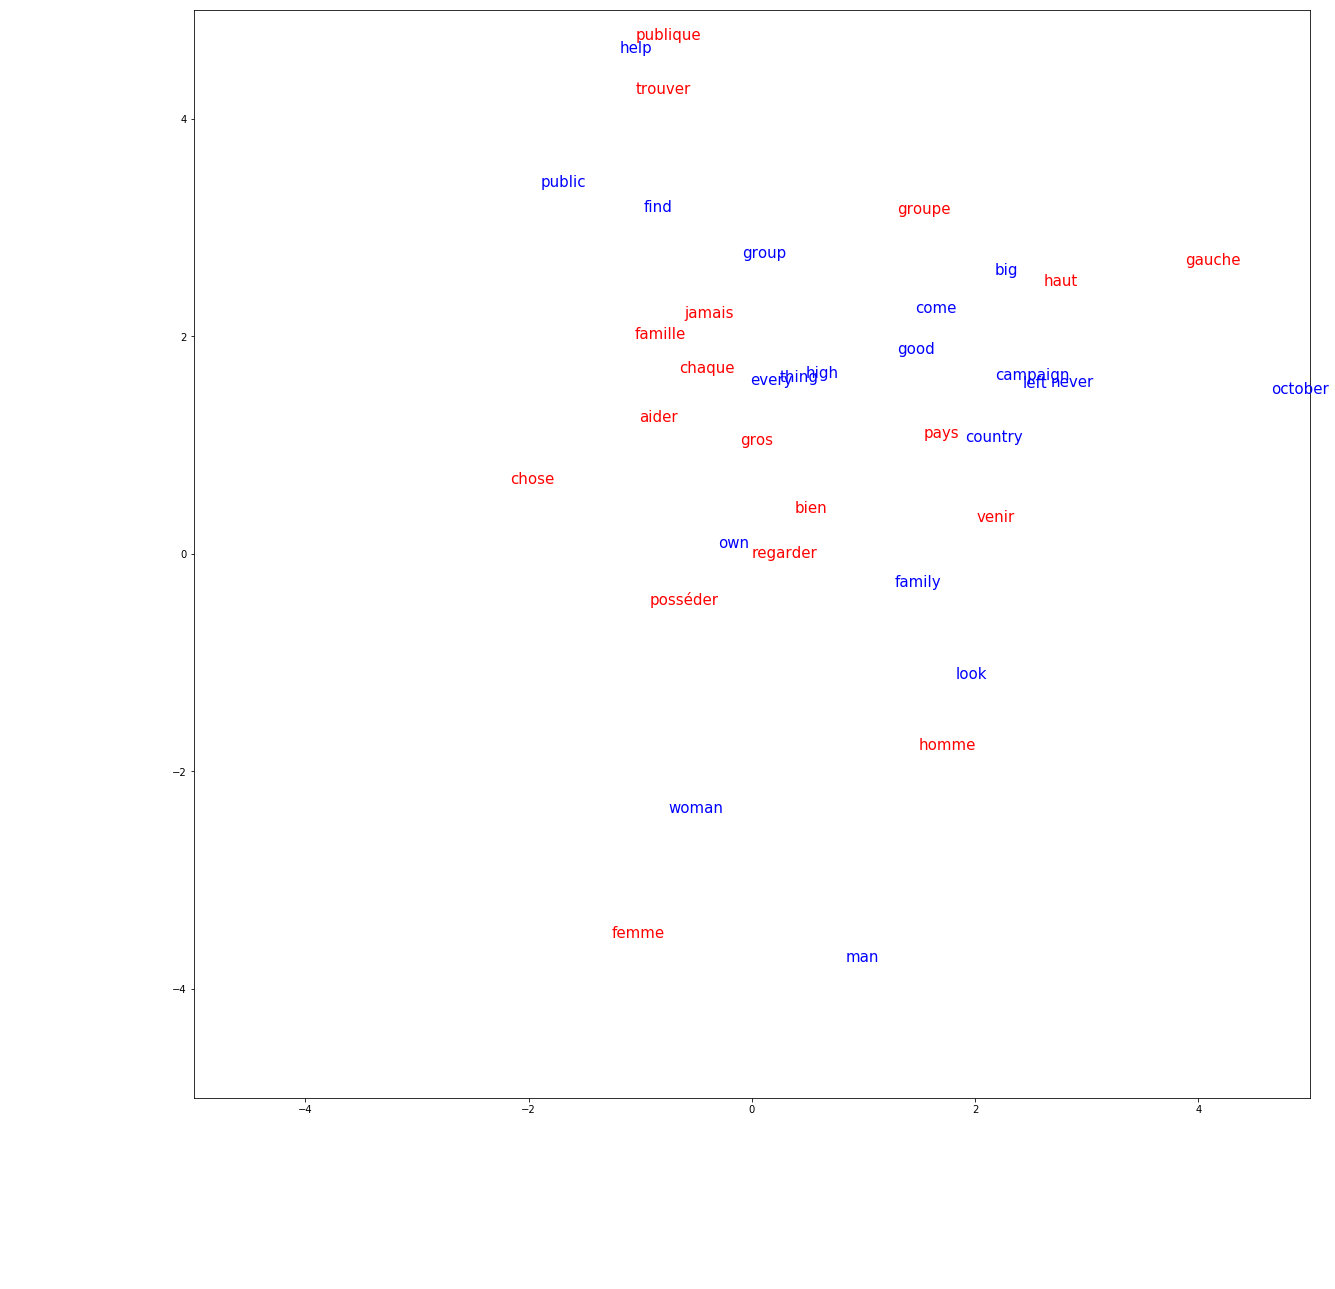

In [69]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=True)

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

In [71]:
import seaborn as sns

In [72]:
# f

In [73]:
def cos(a, b):
    a = a/(a**2).sum(axis=1, keepdims=True)**0.5
    b = b/(b**2).sum(axis=1, keepdims=True)**0.5
    
    return (a * b).sum(axis=1)

def cosine_metrics(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    before = cos(orig1, orig2)
    after = cos(t1, t2)
    
    print("{}|{}|{}|{}".format("lang1", "lang2", "before", "after", fill=' ', align='<', width=10))
    for w1, w2, c1, c2 in zip(lang_1, lang_2, before, after):
        print("{}|{}|{:.4f}|{:.4f}".format(w1, w2, c1, c2, fill=' ', align='<', width=10))
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    plt.figure(figsize=(15, 15))
    sns.heatmap(c1, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2 - c1)
    plt.show()
    
#     print(t1.shape, t2.shape)
#     print(c2.shape)
    s = 0
    for id, w1 in enumerate(lang_1):
#         print(c2[id].argmax())
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        s += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(s/len(lang_1))
#     plt.figure(figsize=(15, 15))
#     sns.heatmap((c2 - c1 > 0.1).astype(np.float32))
#     plt.show()
#     print(np.diag(c2))
#     print(np.diag(c1))
#     print()


In [74]:

def word_translation_cosine(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    
    count = 0
    for id, w1 in enumerate(lang_1):
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(count/len(lang_1))
    
    count = 0
    for id, w2 in enumerate(lang_2):
        translation = lang_1[c2[:, id].argmax()]
        if translation == lang_1[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_1[id]
        print("{} --> {} ({})".format(w2, translation, res))
        
    print(count/len(lang_2))



In [75]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

aider --> help (OK)
famille --> family (OK)
groupe --> high (Fail)
regarder --> find (Fail)
posséder --> every (Fail)
président --> president (OK)
haut --> good (Fail)
homme --> woman (Fail)
venir --> good (Fail)
octobre --> october (OK)
gros --> group (Fail)
chaque --> every (OK)
chose --> find (Fail)
femme --> woman (OK)
trouver --> help (Fail)
publique --> help (Fail)
campagne --> president (Fail)
eau --> water (OK)
gauche --> campaign (Fail)
bien --> find (Fail)
pays --> country (OK)
jamais --> help (Fail)
0.36363636363636365
help --> aider (OK)
family --> famille (OK)
group --> groupe (OK)
look --> regarder (OK)
own --> chose (Fail)
president --> campagne (Fail)
high --> groupe (Fail)
man --> homme (OK)
come --> trouver (Fail)
october --> octobre (OK)
big --> venir (Fail)
every --> trouver (Fail)
thing --> aider (Fail)
woman --> femme (OK)
find --> bien (Fail)
public --> campagne (Fail)
campaign --> campagne (OK)
water --> eau (OK)
left --> bien (Fail)
good --> aider (Fail)
countr

lang1|lang2|before|after
aider|help|0.1497|0.6660
famille|family|-0.0352|0.4810
groupe|group|-0.0241|0.4036
regarder|look|0.0725|0.4173
posséder|own|0.0859|0.0675
président|president|0.0013|0.5960
haut|high|0.1111|0.0647
homme|man|0.0777|0.5460
venir|come|0.1197|0.1588
octobre|october|0.0307|0.4638
gros|big|-0.0656|0.2997
chaque|every|0.1538|0.4872
chose|thing|0.2506|0.2209
femme|woman|0.0529|0.6085
trouver|find|0.1031|0.5118
publique|public|0.1366|0.2940
campagne|campaign|-0.0845|0.5082
eau|water|-0.0158|0.4188
gauche|left|0.0135|0.1325
bien|good|0.0601|0.4215
pays|country|0.0388|0.3184
jamais|never|0.1138|0.1844


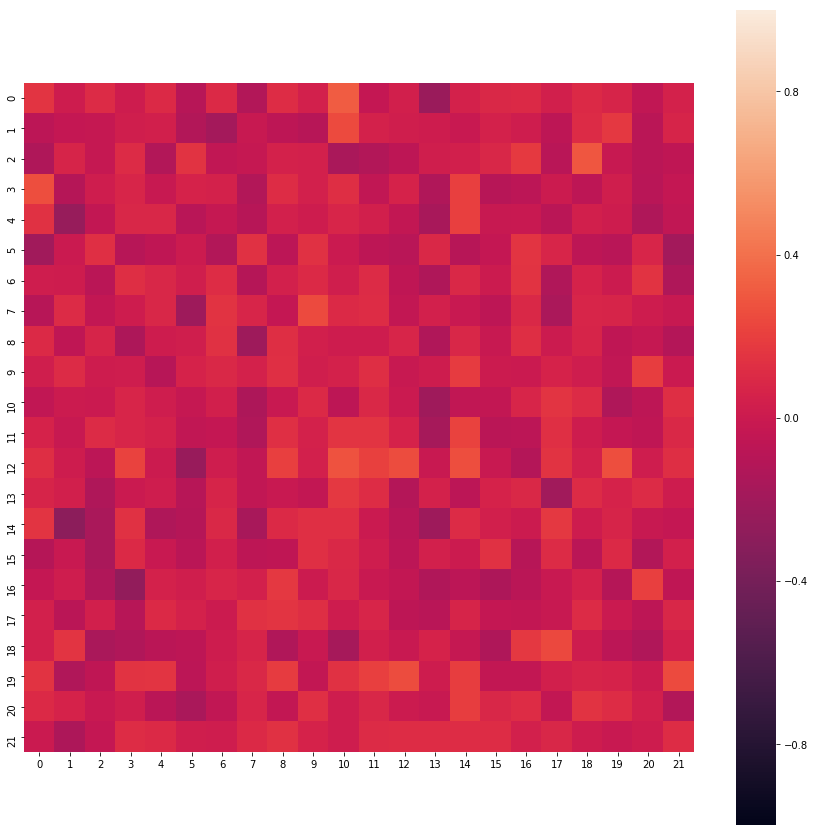

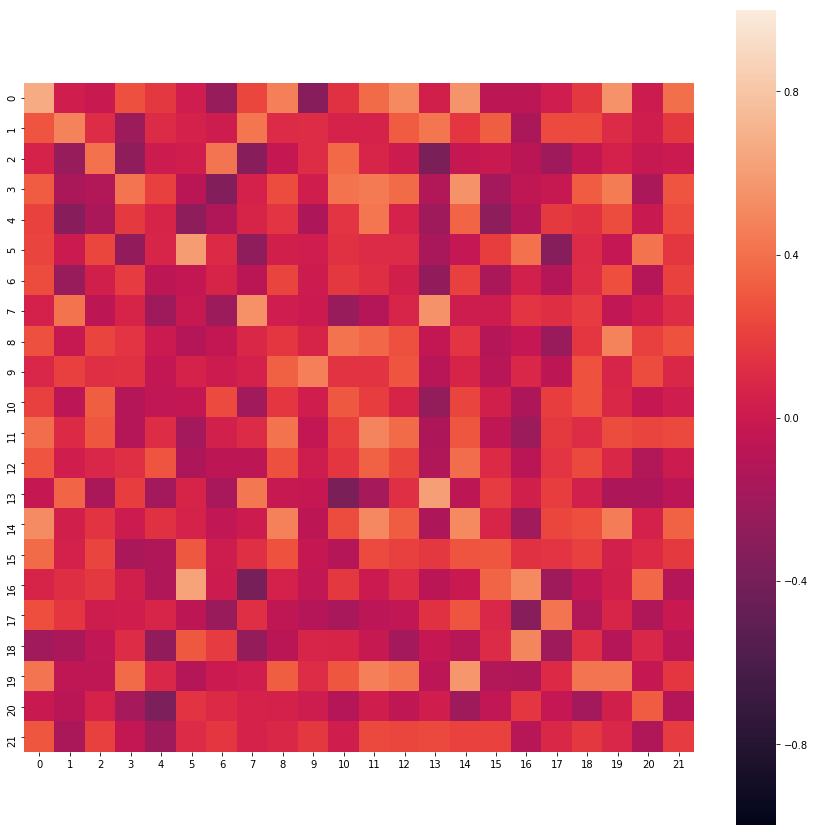

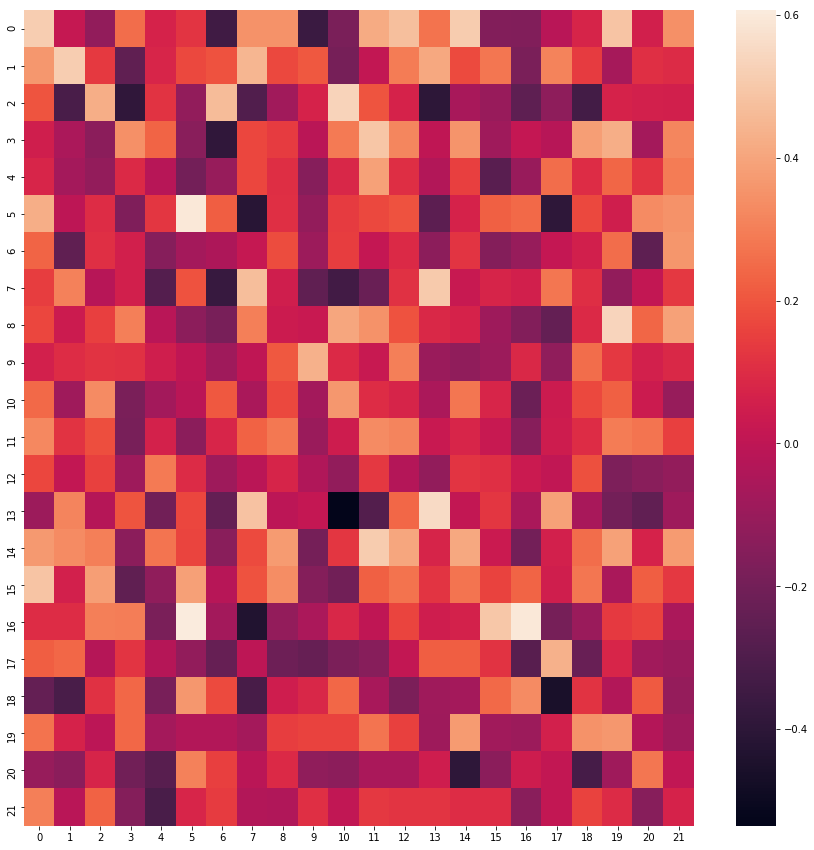

aider --> help (OK)
famille --> family (OK)
groupe --> high (Fail)
regarder --> find (Fail)
posséder --> every (Fail)
président --> president (OK)
haut --> good (Fail)
homme --> woman (Fail)
venir --> good (Fail)
octobre --> october (OK)
gros --> group (Fail)
chaque --> every (OK)
chose --> find (Fail)
femme --> woman (OK)
trouver --> help (Fail)
publique --> help (Fail)
campagne --> president (Fail)
eau --> water (OK)
gauche --> campaign (Fail)
bien --> find (Fail)
pays --> country (OK)
jamais --> help (Fail)
0.36363636363636365


In [76]:
cosine_metrics(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [113]:
cos(np.array([[0, 1, 0], [0, 0, 1]]), np.array([[1, 0, 0], [1, 1, 1]]))

array([0.        , 0.57735027])

In [114]:
cosine_similarity(np.array([[0, 1, 0], [0, 0, 1]]), np.array([[1, 0, 0], [1, 1, 1]]))

array([[0.        , 0.57735027],
       [0.        , 0.57735027]])